# Exercise 1: Wiener Filter

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### (a) Optimal filter weights

In [2]:
R_x = np.array([[5, -1, -2],[-1, 5, -1],[-2, -1, 5]])
r_yx = np.array([1, 5.3, -3.9]).reshape((3,1))
R_x_inv = np.linalg.inv(R_x)

w_o = np.dot(R_x_inv,  r_yx)
print("Optimal weights are:\n", w_o)
print("")
print("inverse of R_x is:\n", R_x_inv)


Optimal weights are:
 [[ 0.2]
 [ 1. ]
 [-0.5]]

inverse of R_x is:
 [[0.26373626 0.07692308 0.12087912]
 [0.07692308 0.23076923 0.07692308]
 [0.12087912 0.07692308 0.26373626]]


# Exercise 2: Steepest Gradient Descent

### (b) Calculate eigenvalues of R_x

In [3]:
eigenvalues = np.linalg.eigvals(R_x)
print("eigenvalues of R_x are:\n", eigenvalues)
# alpha between 0 and 1/7

eigenvalues of R_x are:
 [2.26794919 7.         5.73205081]


### (c) Implementing the filter update rule of the GD algorithm 

#### Loading data

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv('assignment1_data.csv', header=None)

# Assign column names assuming the first column is x and the second column is y
df.columns = ['x', 'y']

# Print the DataFrame to verify the data
print(df)

            x        y
0     0.00000  0.34438
1    -1.10410 -0.17451
2     0.31334 -0.66892
3    -0.88409 -0.14649
4    -1.96720 -0.82132
...       ...      ...
9995 -0.32324  1.42040
9996  1.03690 -0.61886
9997 -3.23190  0.46254
9998  3.57420 -3.25900
9999  1.42070  5.26790

[10000 rows x 2 columns]


#### Initialize filter & Implement the adaptive filter to perform N iterations.


In [5]:
# Initialize weights and learning rate
weights = np.array([0,0,0]).reshape(3,1)
alpha = 0.01 # Should be between 0 and 1/7

J, weights_history = [], []

for i in range(2,len(df)):

    #Predict
    x = np.array([df['x'][i-2],df['x'][i-1],df['x'][i]]).reshape(1,3)[0] #input
    y_hat = np.dot(x, weights)[0] #Prediction

    #Error
    y = df['y'][i] #ground truth y
    J.append(((y-y_hat)**2)) #calculate MSE loss

    #Update
    weights_history.append(weights) #Add current weights to history
    weights = weights + 2*alpha*(r_yx - np.dot(R_x, weights)) #Update weights according to known statistics

print("Final weights are:\n", weights)

Final weights are:
 [[ 0.2]
 [ 1. ]
 [-0.5]]


#### Plotting trajectory of the filter coefficients, together with a contour plot of the objective function J

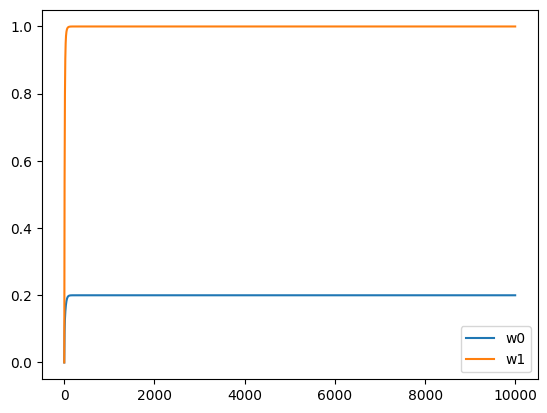

In [6]:
w0,w1,w2 = [],[],[]
for i in range(len(weights_history)):
    w0.append(weights_history[i][0])
    w1.append(weights_history[i][1])
    w2.append(weights_history[i][2])

# Show the convergence of the weights
plt.plot(w0, label='w0')
plt.plot(w1, label='w1')
plt.legend()
plt.show()

# Exercise 3: Newton’s Method

# Exercise 4: LMS and NLMS

# Exercise 5: RLS

# Exercise 6

#### (a) Importing the data and plotting a sample of the dataset.

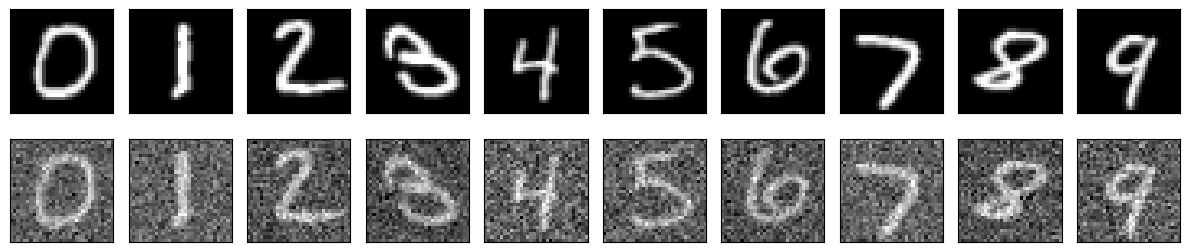

In [5]:
# Import necessary libraries
import torch
from torch import nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from MNIST_dataloader import create_dataloaders

# Define parameters
data_loc = '.'
batch_size = 64

# Create dataloader
train_loader, test_loader = create_dataloaders(data_loc, batch_size)

# Get some examples
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)

# Plot a sample of the dataset
plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_clean_example[i, 0, :, :], cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 10, i + 11)
    plt.imshow(x_noisy_example[i, 0, :, :], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("data_examples.png", dpi=300, bbox_inches='tight')
plt.show()

#### (b) Building a fully connected network with linear layers

In [ ]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 28*28)

    def forward(self, x):
        # Vectorize the 2D image
        x = x.view(x.size(0), -1)
        
        # Pass the vectorized image through the linear layers
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        # Convert the output back to a 2D image
        x = x.view(x.size(0), 1, 28, 28)
        
        return x

#### (c) Define Optimizer SGD

In [ ]:
# Instantiate the model
model = DenoisingNet()
learning_rate = 0.0001

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}%')

#### (c) 

In [6]:
# Instantiate the model
model = DenoisingNet()

# Get some test data
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Make a prediction with the untrained network
outputs = model(images)

# Plot the first 10 test images and their corresponding predictions
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Plot the test image
    axs[0, i].imshow(images[i].view(28, 28).detach().numpy(), cmap='gray')
    axs[0, i].axis('off')

    # Plot the prediction
    axs[1, i].imshow(outputs[i].view(28, 28).detach().numpy(), cmap='gray')
    axs[1, i].axis('off')

plt.show()

NameError: name 'DenoisingNet' is not defined

# Exercise 7